* To investigate the forcings on stratification and total currents. 

In [1]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (
    nc_tools,
    viz_tools,
    tidetools,
    stormtools
)
import datetime, os
from glob import glob
from IPython.core.display import Image,display
from nowcast import figures
import matplotlib.pyplot as plt
import matplotlib as mpl
import pytz 
mpl.rcParams.update({'font.size': 24})
mpl.rcParams["axes.formatter.useoffset"] = False
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'j' : 46,
        'i' : 53},
    'Steveston':{
        'j': 48, ##428
        'i': 52, ##292
    },
    'VENUS East':{
        'lat': 49.0419,
        'lon': -123.3176,
        'depth': 170, 
        'j': 36,##should be 416,
        'i': 43,##should be 283
},    
    'VENUS Central':{
        'lat': 49.0401,
        'lon': -123.4261,
        'depth': 300,
        'j': 44,##should be 424,
        'i': 26,##should be 266
    },
    'Point on transect':{
        'j':36,
        'i':20}
    }

In [3]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]

* Load model result

* Only river

In [4]:
river_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
river_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
river_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')

* No tides

In [5]:
notide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
notide_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_U.nc')
notide_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_V.nc')

* No winds

In [6]:
nowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
nowind_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_U.nc')
nowind_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_V.nc')

* No f

In [7]:
nof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
nof_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_U.nc')
nof_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_V.nc')

 * Combine all forcings

In [8]:
all_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
all_U = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_U.nc')
all_V = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_V.nc')

In [9]:
def plot_stratification_current(stn, dep_ind,ty,grid_T,grid_U,grid_V,time_ind,\
                                smin = 0,smax = 33,umin = -0.5,umax = 0.5):
    """This function is made to plot the 
    stratification and horizontal current of a specific station """
    S = grid_T.variables['vosaline']
    t = grid_T.variables['time_counter']
    dep_T = grid_T.variables['deptht']
    U = grid_U.variables['vozocrtx']
    dep_U = grid_U.variables['depthu']
    V = grid_V.variables['vomecrty']
    dep_V = grid_V.variables['depthv']
    S_stn = S[:,:,sites[stn]['j'],sites[stn]['i']]
    ## tmask
    mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
    tmask = mesh.variables['tmask'][0,:,sites[stn]['j']+380,sites[stn]['i']+240]
    np_mask = np.abs(1-tmask) 
    np_mask=np_mask +np.zeros(S_stn.shape) 
    S_stn = np.ma.masked_array(S_stn,mask=np_mask) ## mask sal=0 by tmask
    time_inds = np.arange(S.shape[0]) ## Define time
    fig, axs = plt.subplots(1,3,figsize = (22,4))
    ## stratification
    ax = axs[0]
    mesh = ax.contourf(time_inds, dep_T[:],np.transpose(S_stn[:]),np.arange(smin, smax+3, 3),cmap = 'jet')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('Practical Salinity')
    ax.set_title(ty+' stratification of '+stn)
    ## U current
    ax = axs[1]
    UU,VV = viz_tools.unstagger(U[:,:,sites[stn]['j']:sites[stn]['j']+2,sites[stn]['i']:sites[stn]['i']+2],\
                                V[:,:,sites[stn]['j']:sites[stn]['j']+2,sites[stn]['i']:sites[stn]['i']+2])
    #rotate
    theta = np.pi*29/180
    UU = UU*np.cos(theta) - VV*np.sin(theta)
    VV = UU*np.sin(theta) +VV*np.cos(theta)

    mesh = ax.contourf(time_inds, dep_U[:],np.transpose(UU[:,:,0,0]),np.arange(umin,umax+0.01,0.02),cmap = 'bwr')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('U Velocity [m/s]')
    ax.set_title(ty+' U velocity of '+stn)
    ## V current
    ax = axs[2]
    mesh = ax.contourf(time_inds, dep_V[:],np.transpose(VV[:,:,0,0]),np.arange(umin,umax+0.01,0.02),cmap = 'bwr')
    cbar=fig.colorbar(mesh,ax = ax)
    cbar.set_label('V Velocity [m/s]')
    ax.set_title(ty+' V velocity of '+stn)
    
    for ax, dep in zip(axs,[dep_T,dep_U,dep_V]):
        ax.set_ylim([dep[dep_ind], dep[0]])
        ax.set_xlim(time_inds[time_ind],time_inds[-1])
        ax.set_xlabel('Time [hr]')
        ax.set_ylabel('Depth [m]')
    return fig

In [10]:
def plot_stn(stn_name):
    """Label the stn """
    fig, ax = plt.subplots(1,1,figsize = (5,5))
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.plot(X[sites[stn_name]['j']+380,sites[stn_name]['i']+240],\
            Y[sites[stn_name]['j']+380,sites[stn_name]['i']+240],'g*',markersize = 10,label = stn_name)
    ax.set_xlim([-123.6,-122.9])
    ax.set_ylim([48.95,49.4])
    ax.legend()
    plt.show()

# Stratification and horizontal currents

* Sandheads

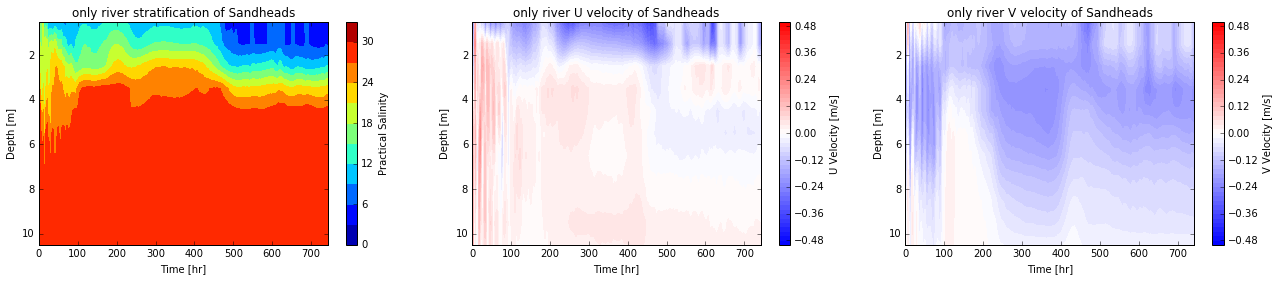

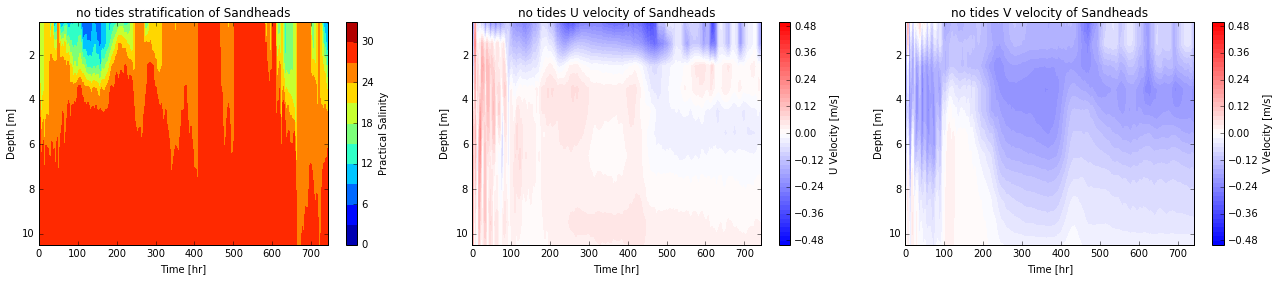

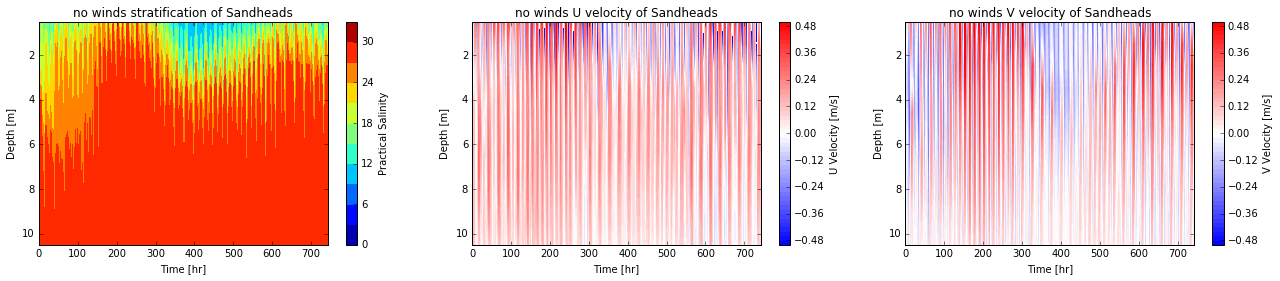

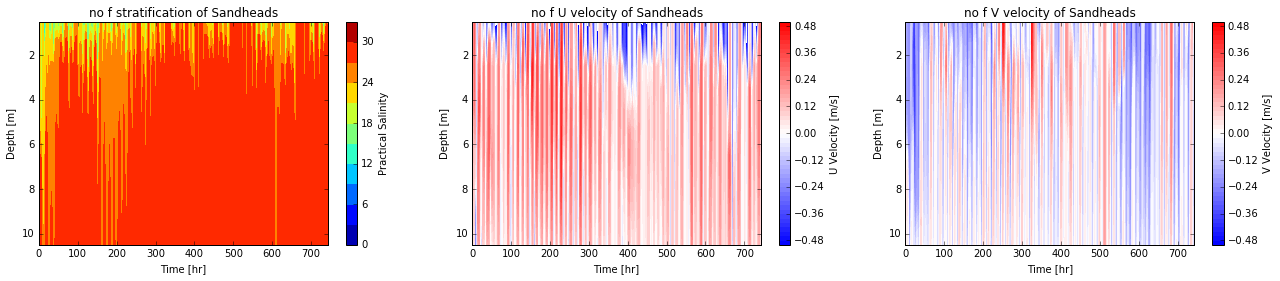

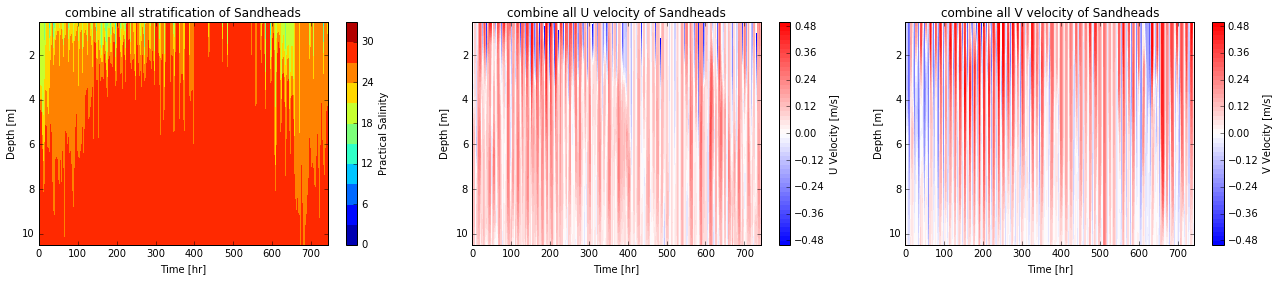

In [11]:
fig = plot_stratification_current('Sandheads',10,'only river',river_T,river_U,river_V,0)
fig = plot_stratification_current('Sandheads',10,'no tides',notide_T,notide_U,notide_V,0)
fig = plot_stratification_current('Sandheads',10,'no winds',nowind_T,nowind_U,nowind_V,0)
fig = plot_stratification_current('Sandheads',10,'no f',nof_T,nof_U,nof_V,0)
fig = plot_stratification_current('Sandheads',10,'combine all',all_T,all_U,all_V,0)

* zoom in last five days

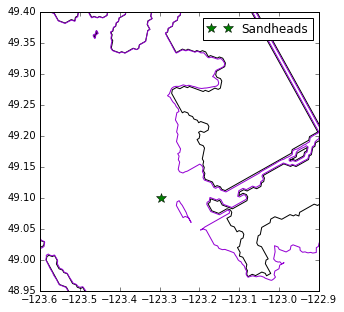

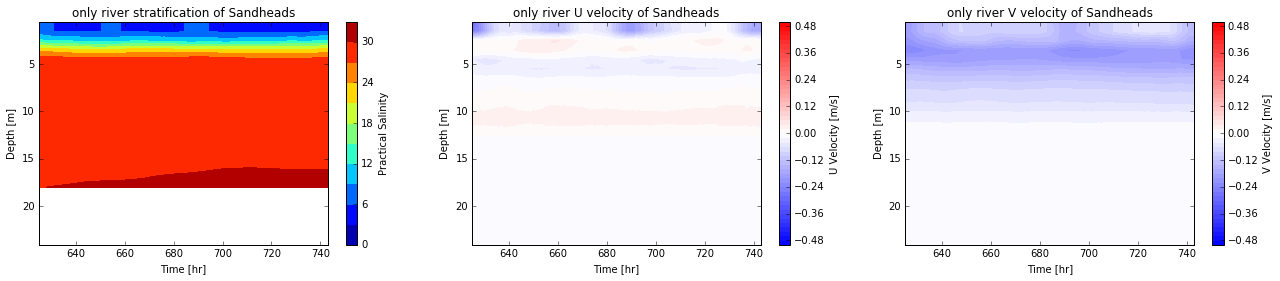

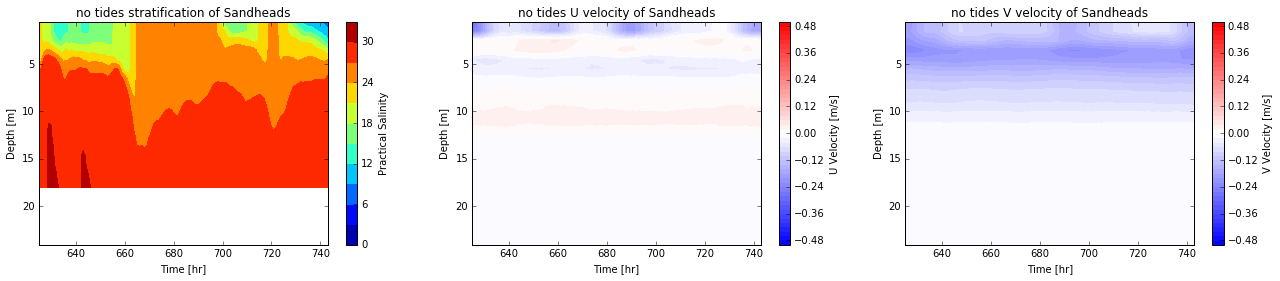

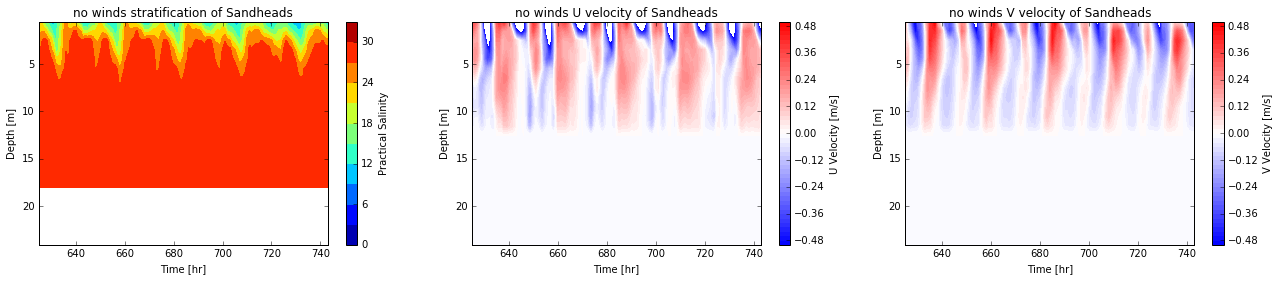

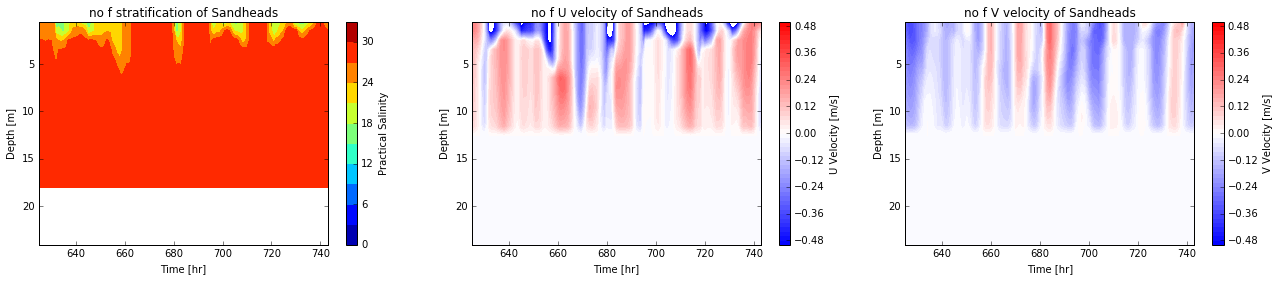

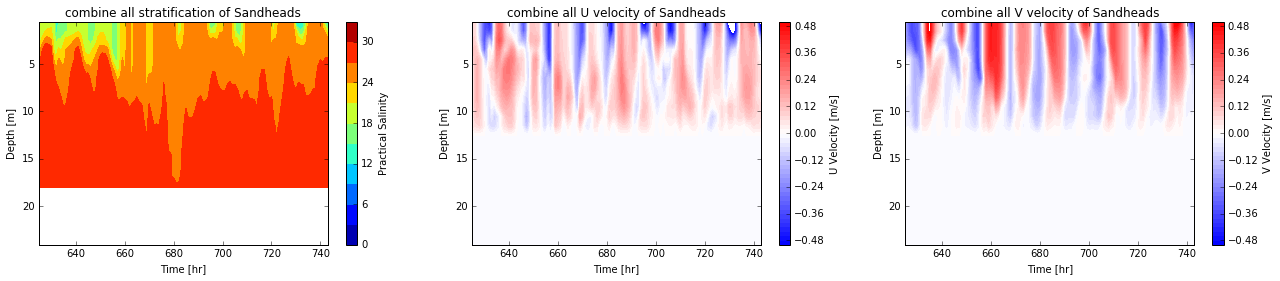

In [12]:
plot_stn('Sandheads')
fig = plot_stratification_current('Sandheads',20,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('Sandheads',20,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('Sandheads',20,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('Sandheads',20,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('Sandheads',20,'combine all',all_T,all_U,all_V,625)

* Steveston

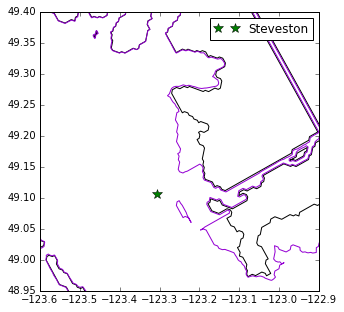

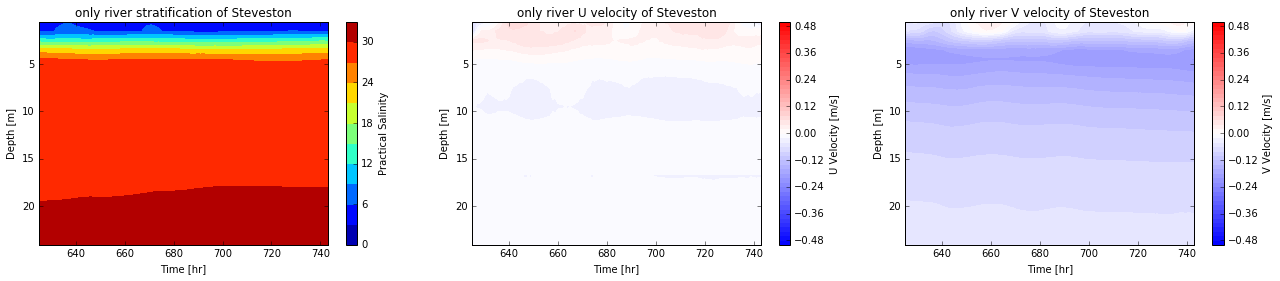

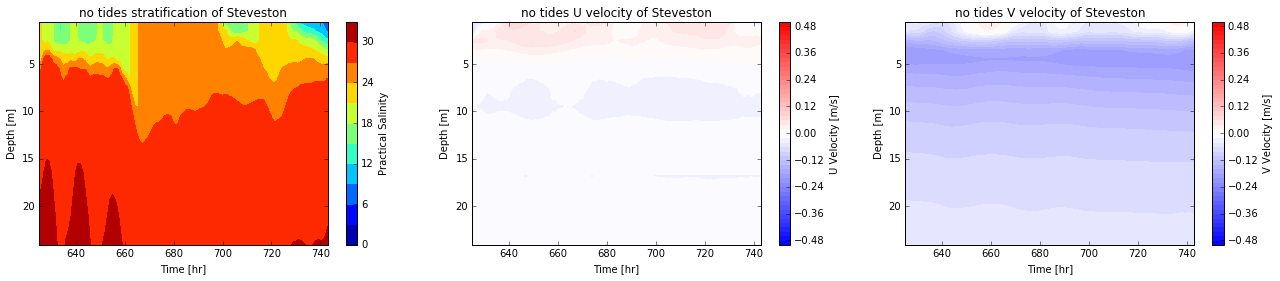

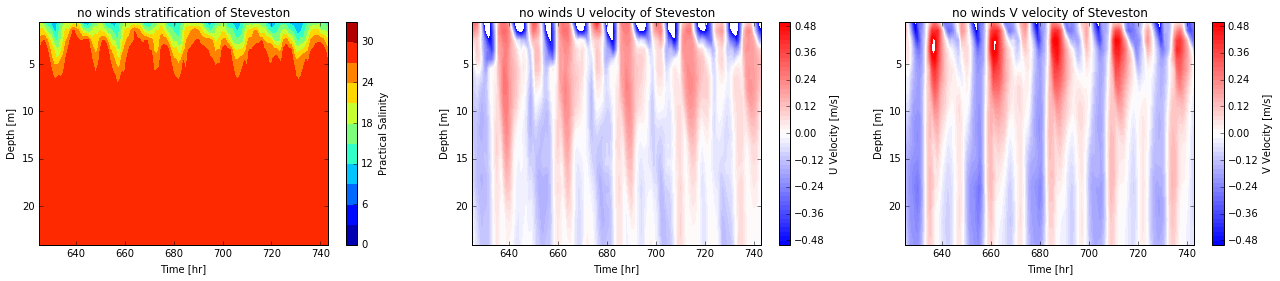

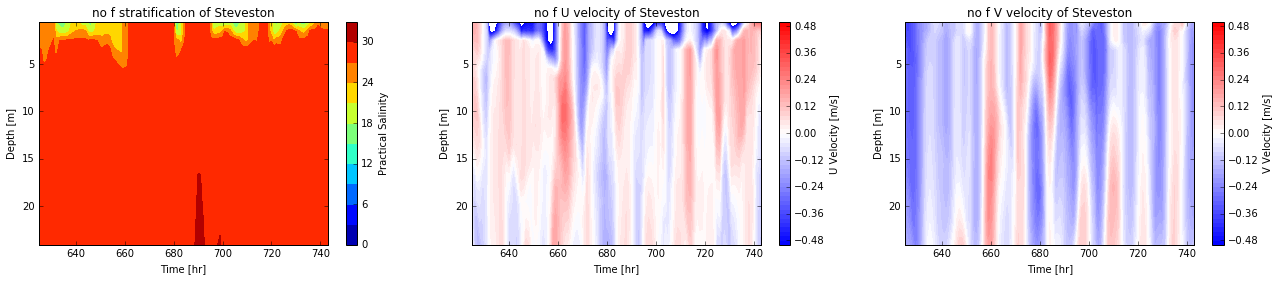

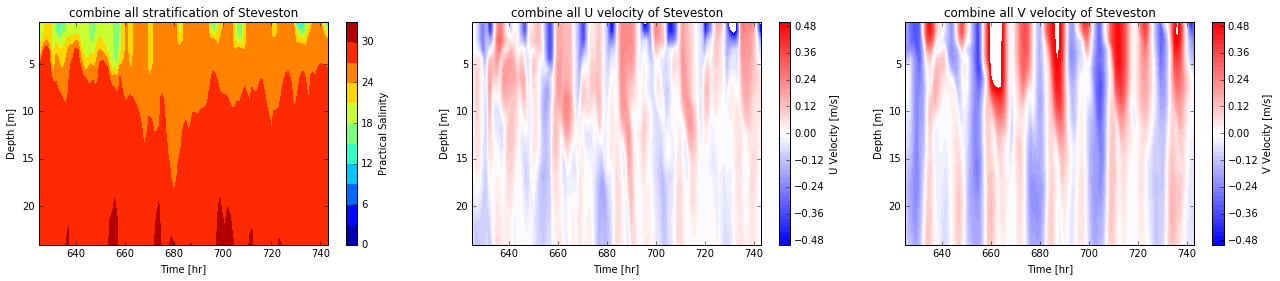

In [13]:
plot_stn('Steveston')
fig = plot_stratification_current('Steveston',20,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('Steveston',20,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('Steveston',20,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('Steveston',20,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('Steveston',20,'combine all',all_T,all_U,all_V,625)

* VENUS Central

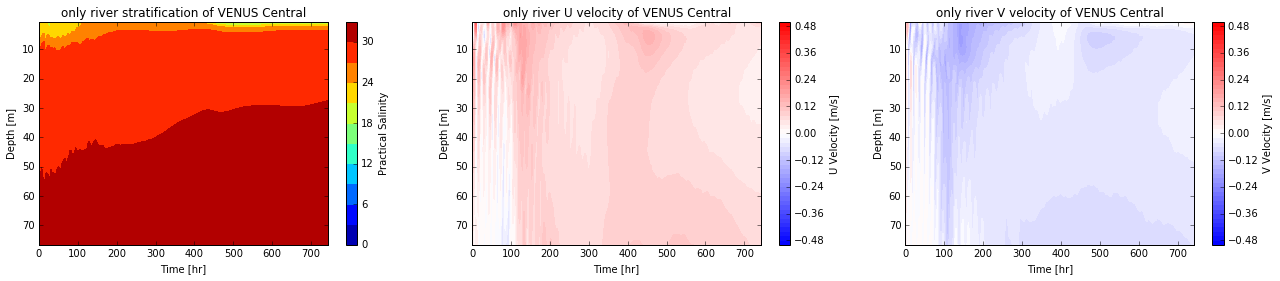

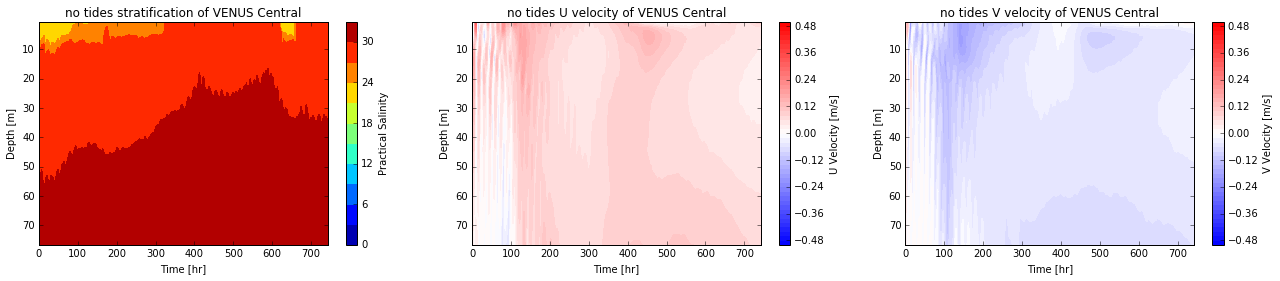

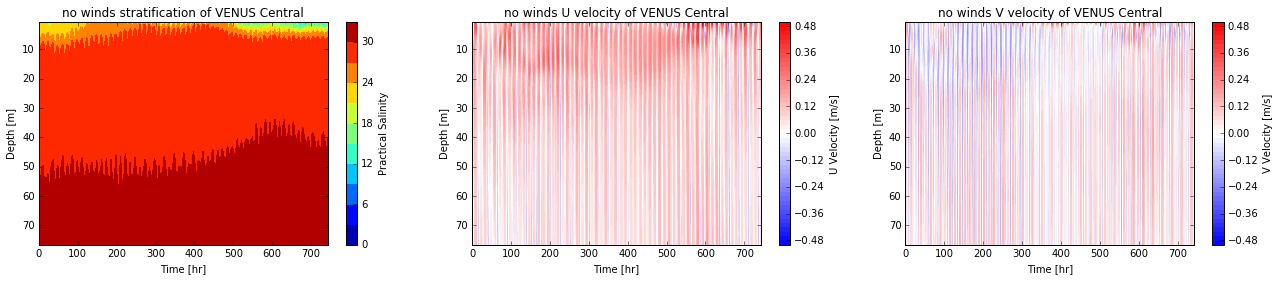

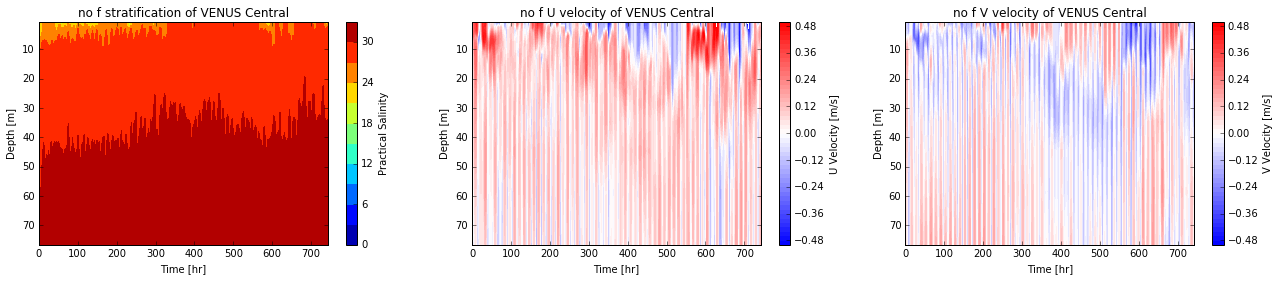

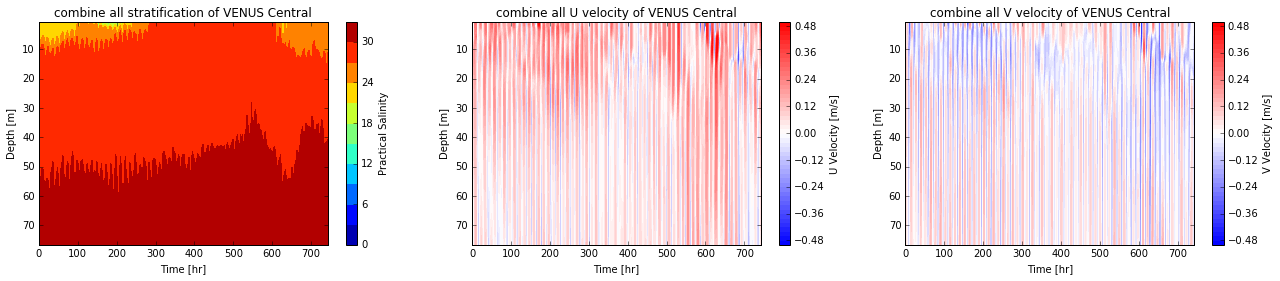

In [14]:
fig = plot_stratification_current('VENUS Central',25,'only river',river_T,river_U,river_V,0)
fig = plot_stratification_current('VENUS Central',25,'no tides',notide_T,notide_U,notide_V,0)
fig = plot_stratification_current('VENUS Central',25,'no winds',nowind_T,nowind_U,nowind_V,0)
fig = plot_stratification_current('VENUS Central',25,'no f',nof_T,nof_U,nof_V,0)
fig = plot_stratification_current('VENUS Central',25,'combine all',all_T,all_U,all_V,0)

* zoom in last five days

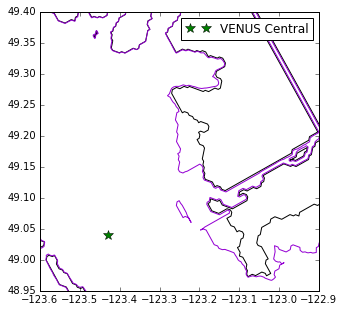

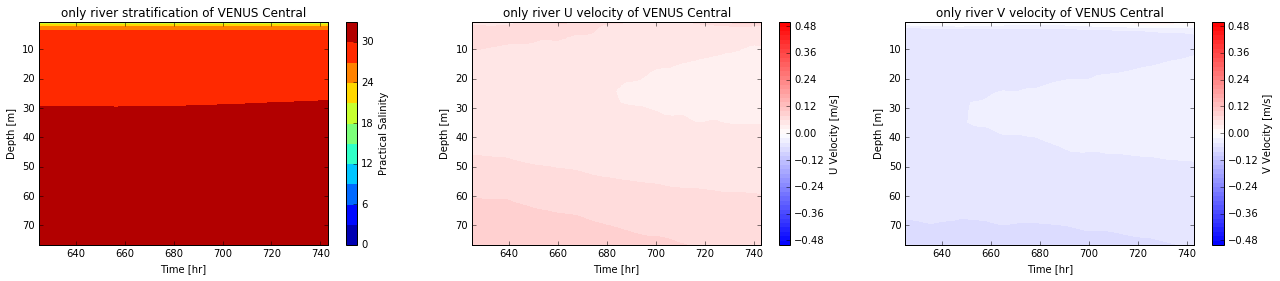

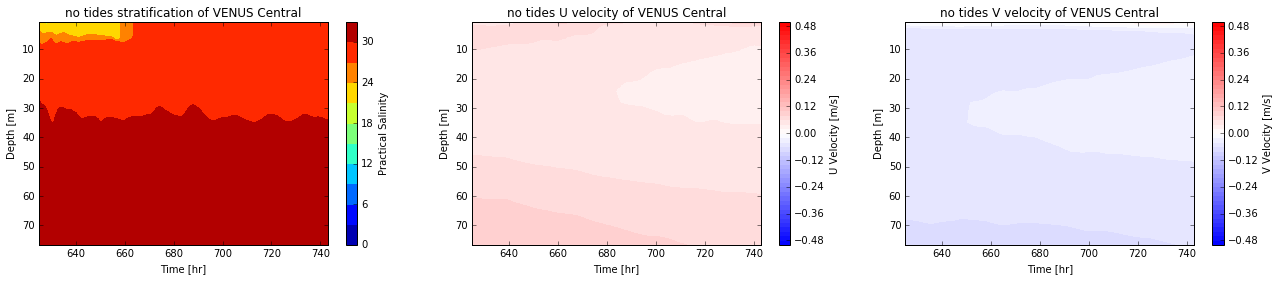

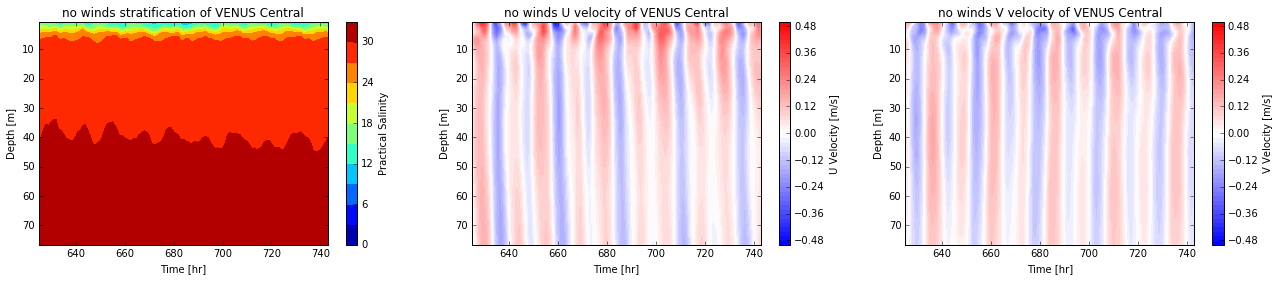

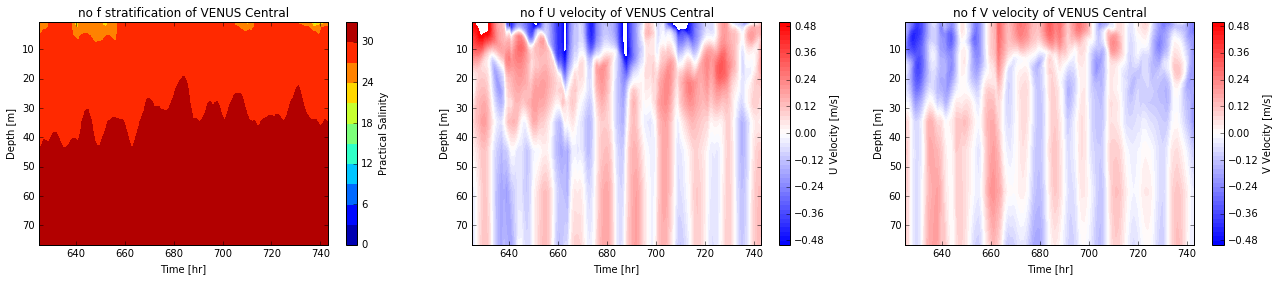

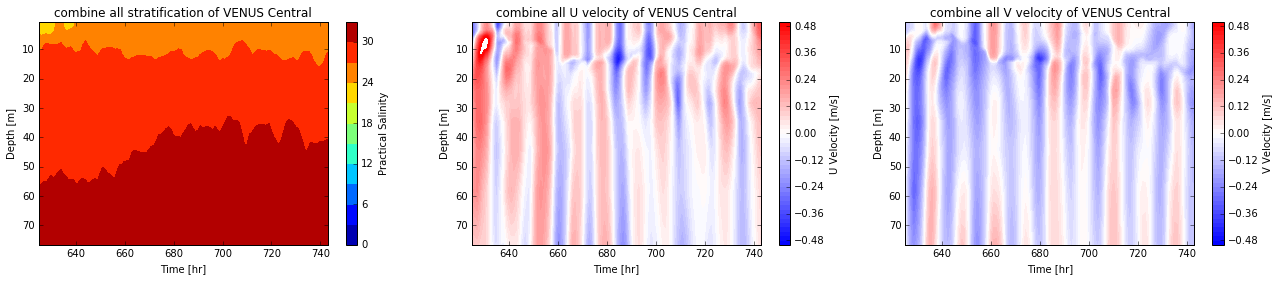

In [15]:
plot_stn('VENUS Central')
fig = plot_stratification_current('VENUS Central',25,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('VENUS Central',25,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('VENUS Central',25,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('VENUS Central',25,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('VENUS Central',25,'combine all',all_T,all_U,all_V,625)

* VENUS East

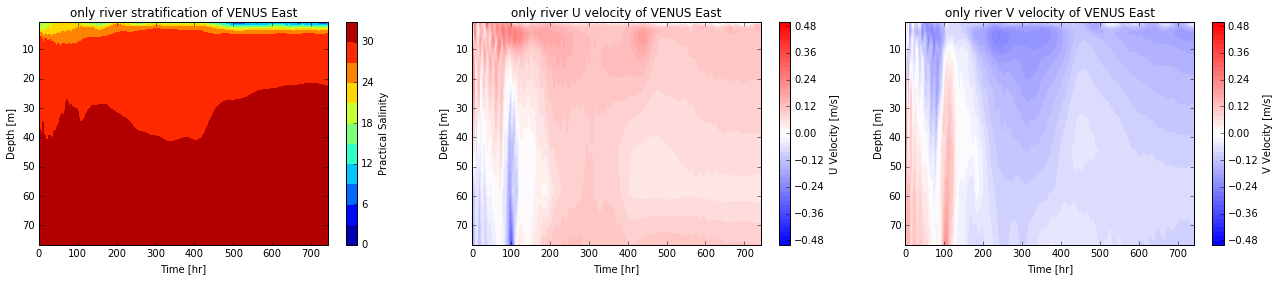

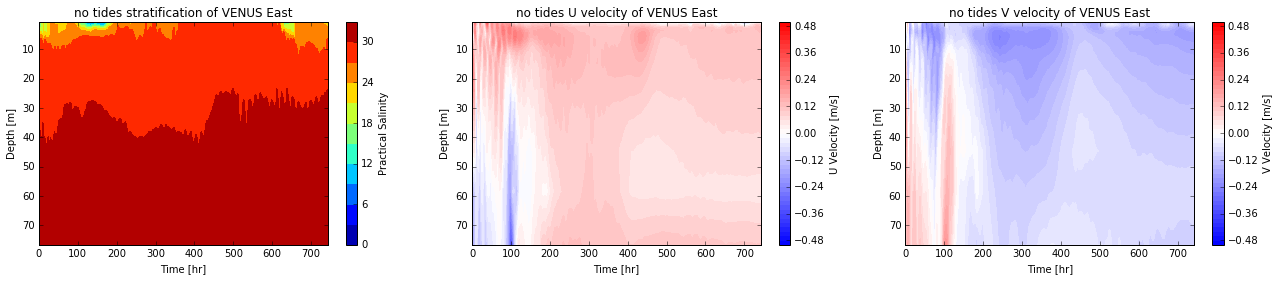

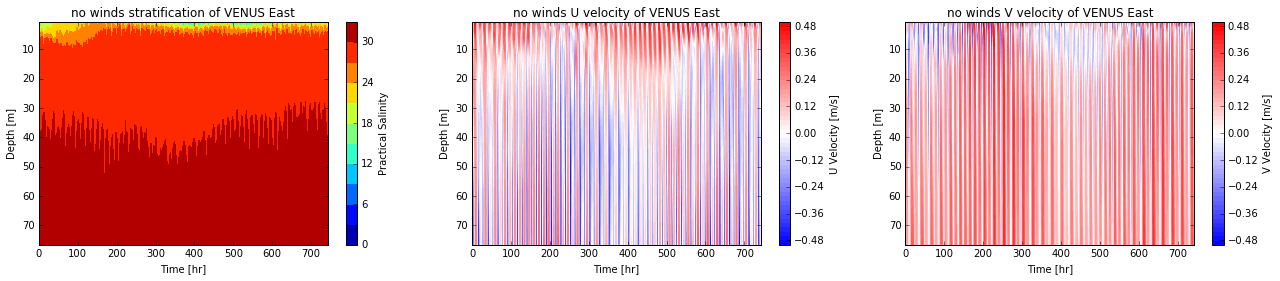

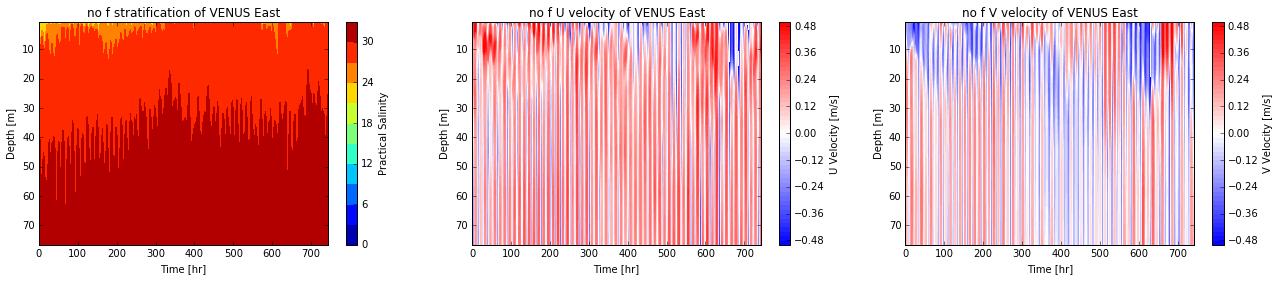

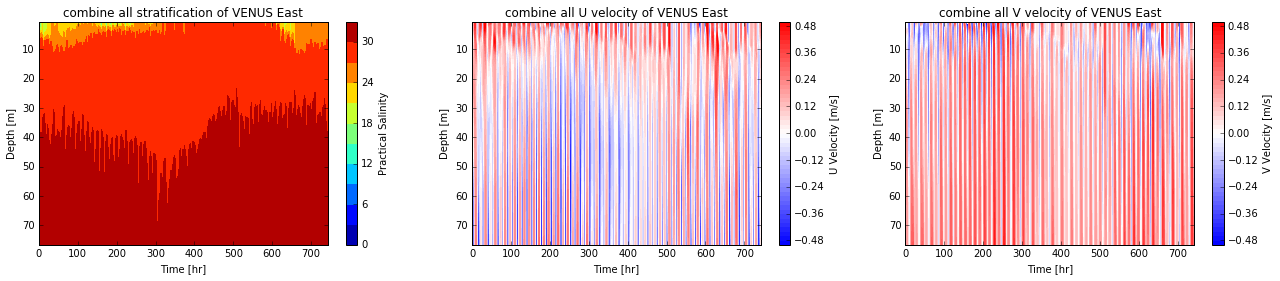

In [16]:
fig = plot_stratification_current('VENUS East',25,'only river',river_T,river_U,river_V,0)
fig = plot_stratification_current('VENUS East',25,'no tides',notide_T,notide_U,notide_V,0)
fig = plot_stratification_current('VENUS East',25,'no winds',nowind_T,nowind_U,nowind_V,0)
fig = plot_stratification_current('VENUS East',25,'no f',nof_T,nof_U,nof_V,0)
fig = plot_stratification_current('VENUS East',25,'combine all',all_T,all_U,all_V,0)

* zoom in last five days

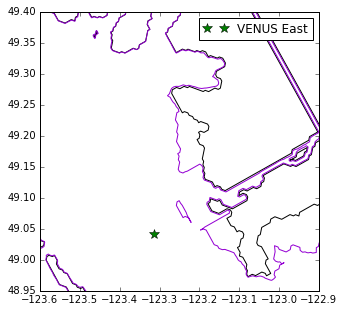

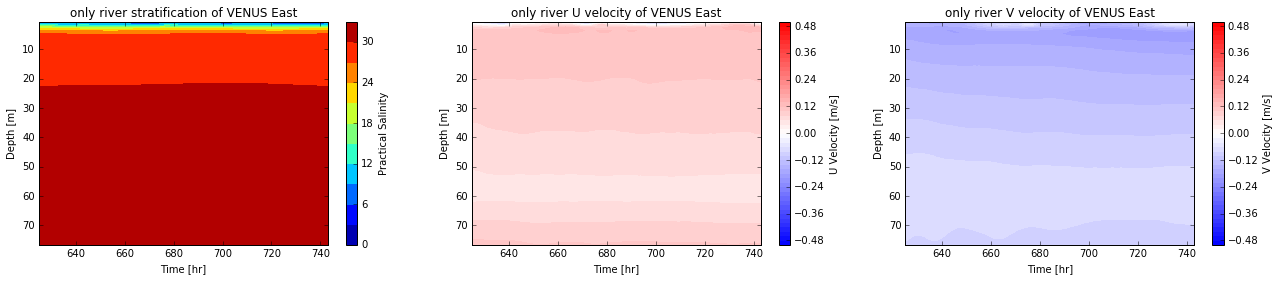

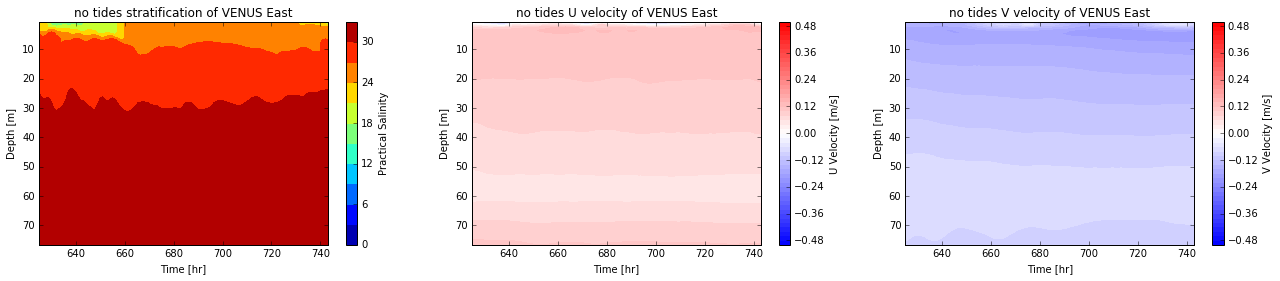

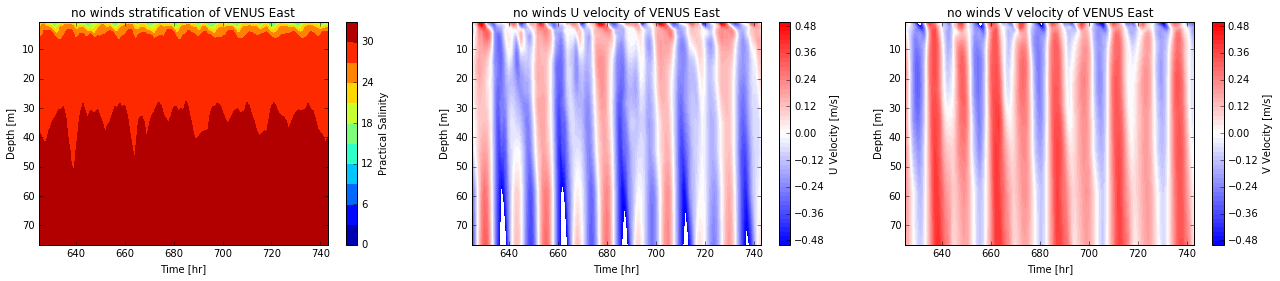

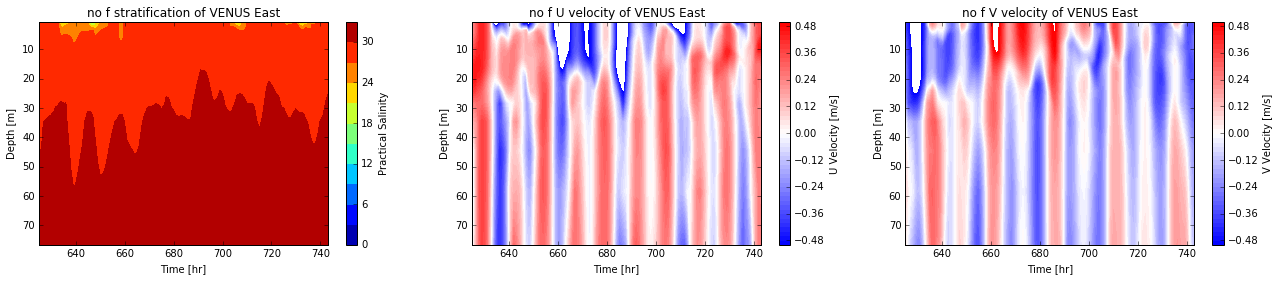

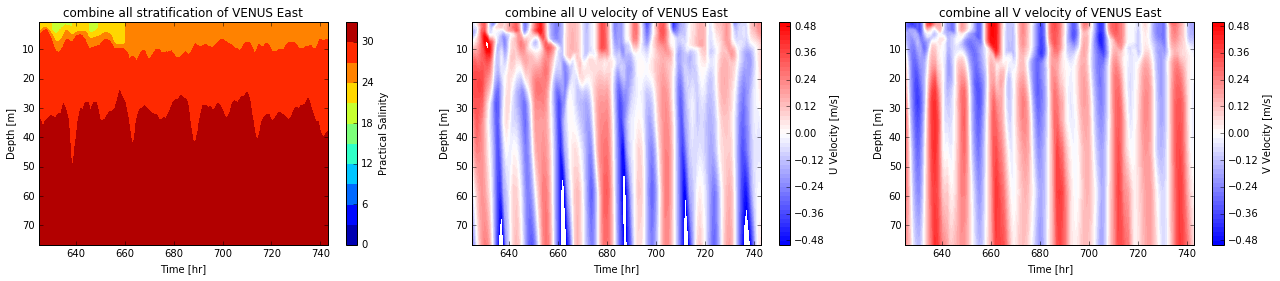

In [17]:
plot_stn('VENUS East')
fig = plot_stratification_current('VENUS East',25,'only river',river_T,river_U,river_V,625)
fig = plot_stratification_current('VENUS East',25,'no tides',notide_T,notide_U,notide_V,625)
fig = plot_stratification_current('VENUS East',25,'no winds',nowind_T,nowind_U,nowind_V,625)
fig = plot_stratification_current('VENUS East',25,'no f',nof_T,nof_U,nof_V,625)
fig = plot_stratification_current('VENUS East',25,'combine all',all_T,all_U,all_V,625)

# Select a transect

In [11]:
def R_mix(S,t,dep_ind):
    """This function was made to calculate the R_mix ratio,
    defined by S_surf/S0, S0 is the mean salinity in the water column"""
    S0 = np.nanmean(S[t,0:dep_ind],axis = 0)
    R_mix = S[t,0]/S0
    return R_mix

In [21]:
def plot_salinity_estuary(grid_T,dep_ind,grid_T2 = None,title = ' no wind',string ='tides',smin = 0, smax = 36):
    """This function was made to plot salinity along the transect in 
    different forcing cases"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    dep = grid_T.variables['deptht']
    ## tmask
    mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
    tmask = mesh.variables['tmask'][0,:,380:510,240:397]
    np_mask = np.abs(1-tmask) 
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col',sharey='row',figsize = (14,8))
    f.subplots_adjust(hspace=0)
    cmap = plt.get_cmap('jet')
    strings = {'tides': {'t_ind_high': -3,'t_ind_low':-12},
              'winds':{'t_ind_high':-1,'t_ind_low':-1}}

    ax = ax1
    r_mix = R_mix(S,strings[string]['t_ind_high'],dep_ind)
    ax.plot(lon[36,4:123],r_mix[36,4:123],'r-*')
    
    ax = ax2
    r_mix = R_mix(S,strings[string]['t_ind_low'],dep_ind)  
    ax.plot(lon[36,4:123],r_mix[36,4:123],'r-*')
    
    ax = ax3
    np_mask=np_mask +np.zeros(S[strings[string]['t_ind_high']].shape) 
    S_else = np.ma.masked_array(S[strings[string]['t_ind_high']],mask=np_mask) ## mask sal=0 by tmask
    mesh = ax.contourf(lon[36,4:123], dep[:], S_else[:,36,4:123],np.arange(smin,smax+3,3),cmap = cmap)
    
    ax = ax4
    np_mask=np_mask +np.zeros(S[strings[string]['t_ind_low']].shape) 
    S_else = np.ma.masked_array(S[strings[string]['t_ind_high']],mask=np_mask) ## mask sal=0 by tmask
    mesh =ax.contourf(lon[36,4:123], dep[:], S_else[:,36,4:123],np.arange(smin,smax+3,3),cmap = cmap)

    for ax in [ax3,ax4]:
        cbar=f.colorbar(mesh,ax = ax,orientation ='horizontal')
        cbar.set_label('Practical Salinity')
        ax.set_xlabel('Lon')
        ax.set_ylabel('Depth [m]')
        ax.set_xlim([lon[36,4],lon[36,123]])
        ax.set_ylim([dep[dep_ind],0])
    for ax, titl in zip([ax1,ax2],['High tide of'+title, 'Low tide of'+title]):
        ax.set_ylim([0,1])
        ax.annotate('Estuary',(-123.05,0))
        ax.annotate('Mouth',(-123.16,0))
        ax.annotate('Near field',(-123.25,0))
        ax.annotate('Far field',(-123.4,0))
        ax.set_ylabel('Rmix')
        ax.set_title(titl)

    return f

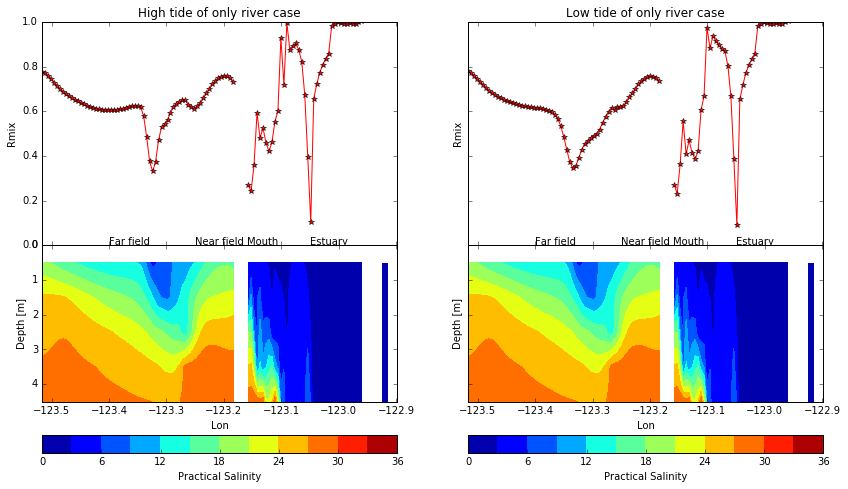

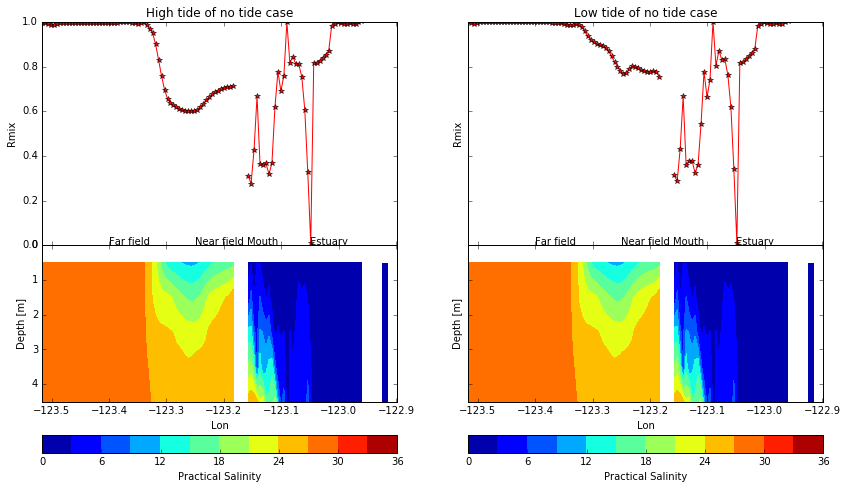

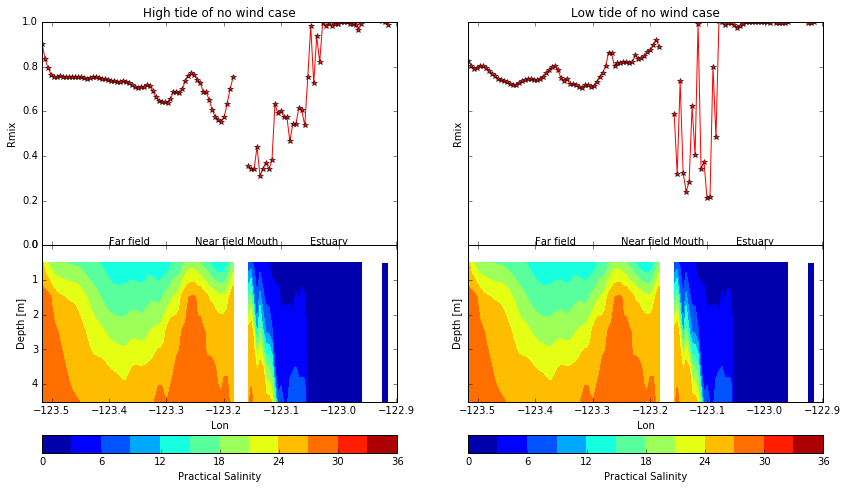

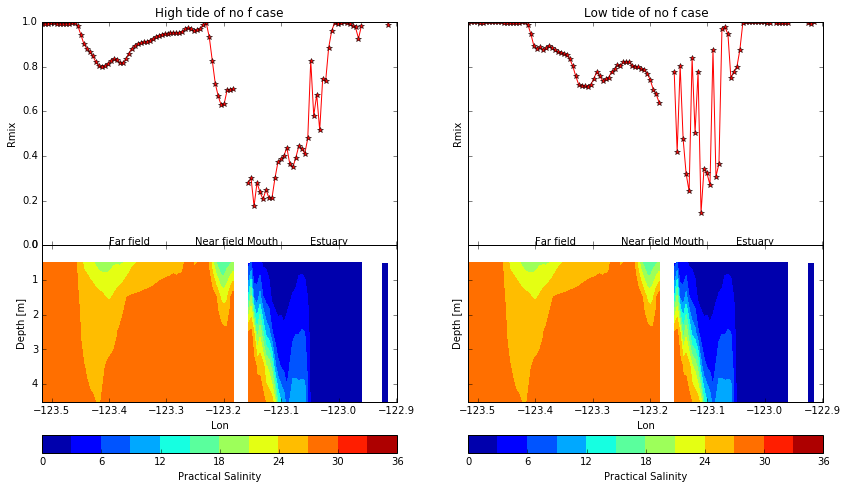

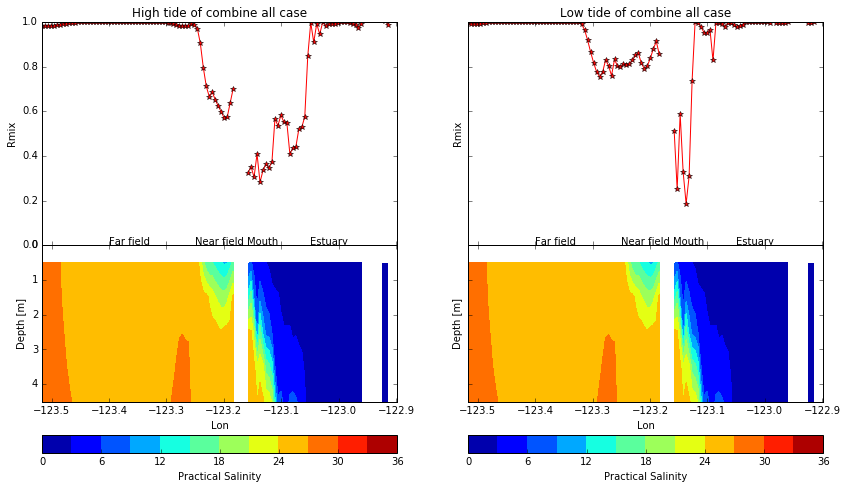

In [23]:
fig = plot_salinity_estuary(river_T,4, title = ' only river case')
fig = plot_salinity_estuary(notide_T,4,title = ' no tide case')
fig = plot_salinity_estuary(nowind_T,4,title = ' no wind case')
fig = plot_salinity_estuary(nof_T,4,title = ' no f case')
fig = plot_salinity_estuary(all_T,4,title = ' combine all case')

* Fairly well mixed with all conditions in the far field plume in the upper 5m.
* Winds play an important role in both far and near field plume for vertical mxing.
* Almost no effect of mixing caused by tides in the far field, also tiny influence in the near field, why?
    1) Barotopic tidal amplitude is faround 2m in the mouth region, should be quite mixed in the upper 2m.
    2) Baroclinic tides??

In [13]:
## load t_tide
tfile = '/ocean/jieliu/research/meopar/tools/SalishSeaNowcast/\
tidal_predictions/Point Atkinson_t_tide_compare8_31-Dec-2013_02-Dec-2015.csv'
ttide, msl = stormtools.load_tidal_predictions(tfile)

In [14]:
def find_ind_tide(run_low, run_up, run_label1,run_label2):
    """To find index of ttide within a time range"""
    run_low = run_low.replace(tzinfo=pytz.utc) ## convert model datetime to tzinfo=<UTC>
    run_up = run_up.replace(tzinfo=pytz.utc) ## the time i want to label on the plot
    run_label1 = run_label1.replace(tzinfo=pytz.utc)
    run_label2 = run_label2.replace(tzinfo=pytz.utc)
    ttide_dt  = ttide.time.dt.to_pydatetime() ## convert ttide.time (pandas) to datetime
    for i in range(len(ttide_dt)):
        if ttide_dt[i]== run_low:
            low_ind = i
        if ttide_dt[i]== run_up:
            up_ind = i  
        if ttide_dt[i]== run_label1:
            lab_ind1 = i  
        if ttide_dt[i]== run_label2:
            lab_ind2 = i  
    return low_ind, up_ind, lab_ind1,lab_ind2

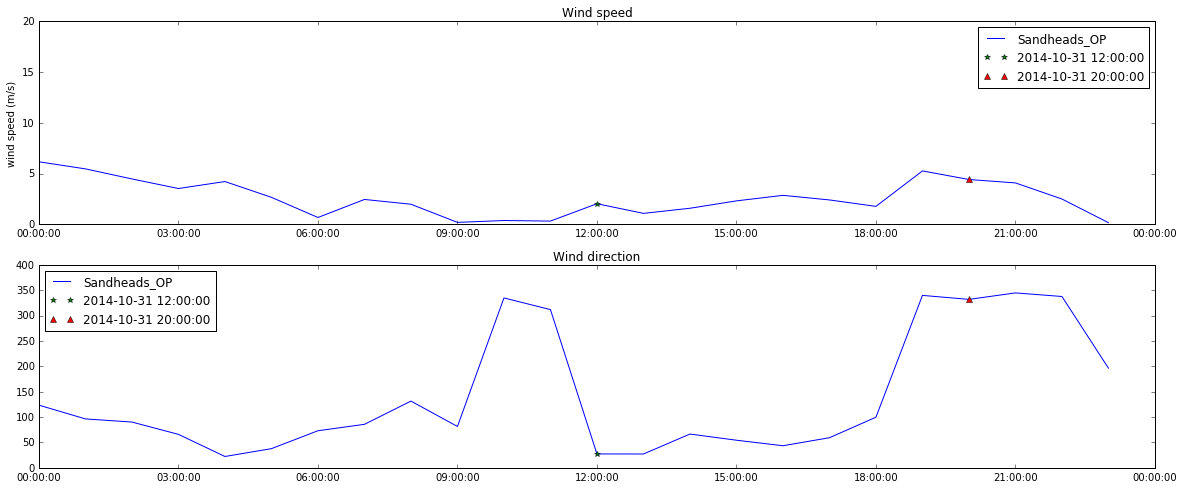

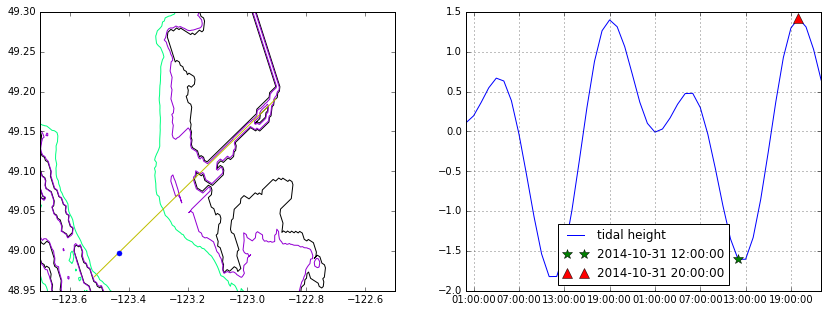

In [15]:
fig, axs = plt.subplots(1,2,figsize = (14,5))
ax = axs[0]
viz_tools.plot_coastline(ax, grid6, coords = 'map')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 50,color = 'springgreen')
lon = all_T.variables['nav_lon']
lat = all_T.variables['nav_lat']
ax.plot(lon[36,4:123],lat[36,4:123],'y-') ## transect
ax.plot(lon[36,20],lat[36,20],'b.',markersize = 10)
#ax.text(0, 0, "Direction", ha="center", va="center", size=15)
ax.set_xlim([-123.7,-122.5])
ax.set_ylim([48.95,49.3])
ax = axs[1]
run_low = datetime.datetime(2014,10,30)
run_up = datetime.datetime(2014,11,1)
run_label1 = datetime.datetime(2014,10,31,12)
run_label2 = datetime.datetime(2014,10,31,20)
low_ind,up_ind,lab_ind1,lab_ind2 = find_ind_tide(run_low,run_up,run_label1,run_label2)
ax.plot(ttide.time[low_ind:up_ind], ttide.pred_all[low_ind:up_ind],label = 'tidal height')
ax.plot(ttide.time[lab_ind1],ttide.pred_all[lab_ind1],'g*',markersize = 10,label = run_label1)
ax.plot(ttide.time[lab_ind2],ttide.pred_all[lab_ind2],'r^',markersize = 10,label = run_label2)
ax.legend(loc = 'best')
ax.grid('on')
Image(filename='/ocean/jieliu/research/meopar/surface current/wind_31oct14.png')

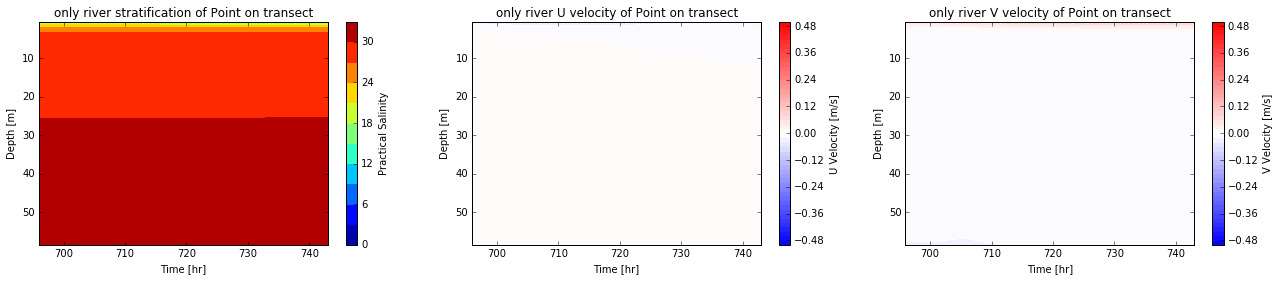

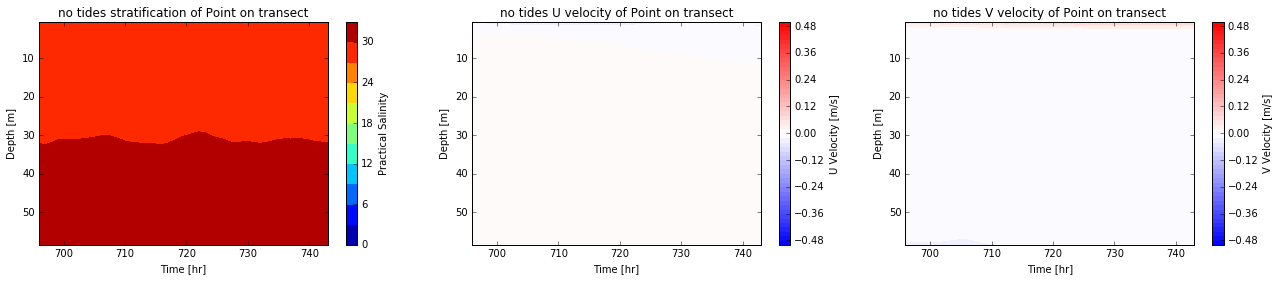

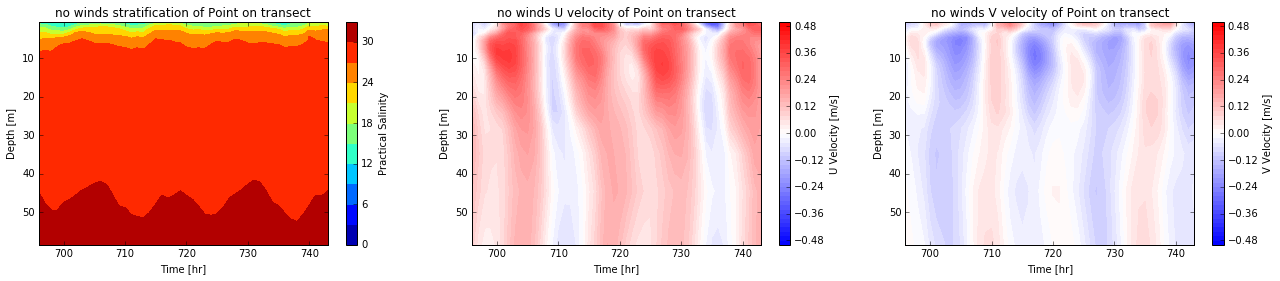

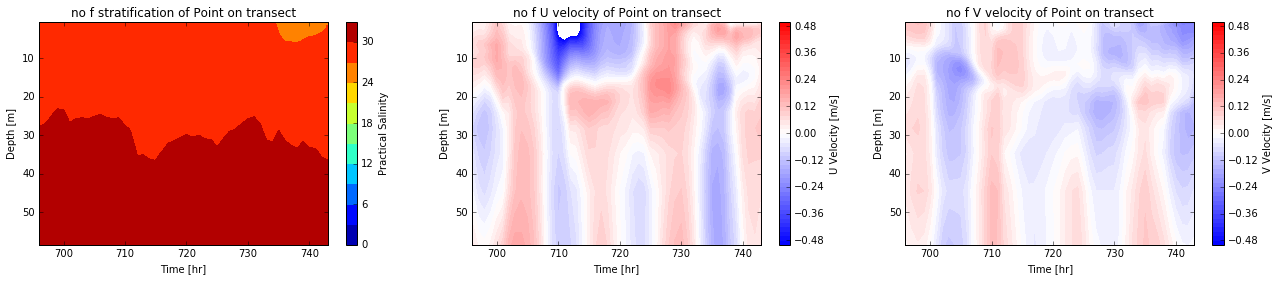

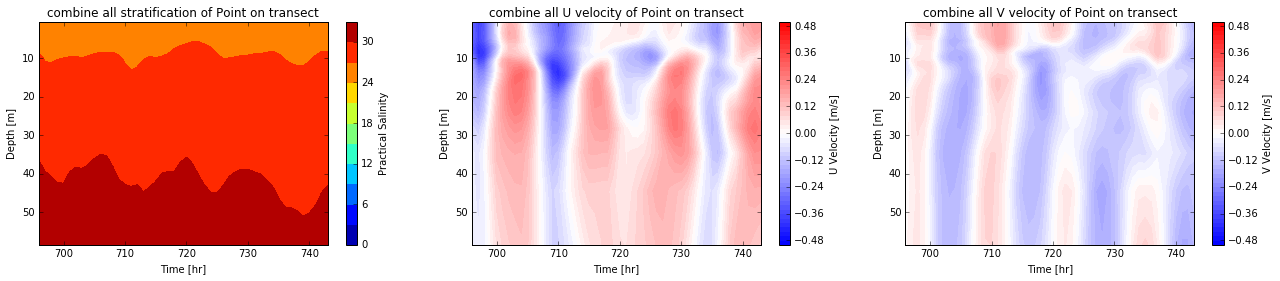

In [10]:
## last 3 days
fig = plot_stratification_current('Point on transect',24,'only river',river_T,river_U,river_V,696)
fig = plot_stratification_current('Point on transect',24,'no tides',notide_T,notide_U,notide_V,696)
fig = plot_stratification_current('Point on transect',24,'no winds',nowind_T,nowind_U,nowind_V,696)
fig = plot_stratification_current('Point on transect',24,'no f',nof_T,nof_U,nof_V,696)
fig = plot_stratification_current('Point on transect',24,'combine all',all_T,all_U,all_V,696)

* No tides case, to look at the salinity at final time in response with high wind, normal wind and no wind with a almost constant river flow.

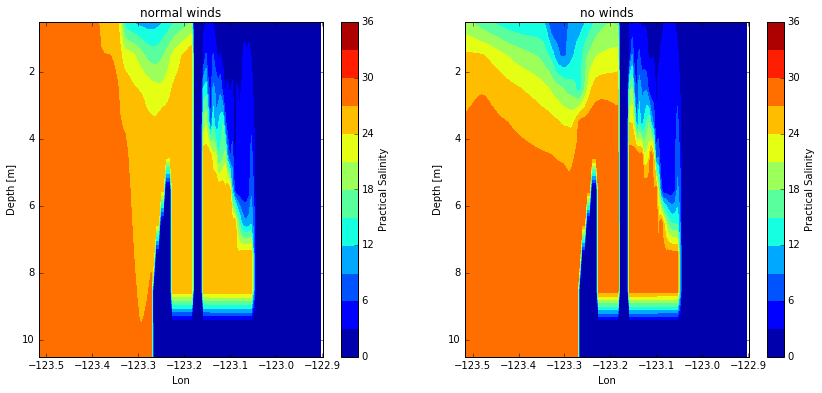

In [22]:
fig = plot_salinity_estuary(notide_T,10,river_T,title = ' winds', string = 'winds')

# Final circulation pattern

In [23]:
def plot_spatial_circulation(grid_T,grid_U,grid_V,dep_ind,string,smin = 0,smax = 30,st=3):
    """This function was made to plot the circulation pattern of each case of 
    the final time"""
    fig, ax= plt.subplots(1,1,figsize=(6,6))
    S = grid_T.variables['vosaline'][-1,dep_ind,:,:]
    dep = grid_T.variables['deptht']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    U = grid_U.variables['vozocrtx']
    V = grid_V.variables['vomecrty']
    UU,VV = viz_tools.unstagger(U[-1,dep_ind,:,:],V[-1,dep_ind,:,:])
    #rotate
    theta = np.pi*29/180
    UU = UU*np.cos(theta) - VV*np.sin(theta)
    VV = UU*np.sin(theta) +VV*np.cos(theta)
    mesh=ax.pcolormesh(lon,lat,S[:],cmap='spectral')
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label('Practical Salinity')
    mesh.set_clim(vmin=smin, vmax=smax)
    #quivers
    lon = grid_T.variables['nav_lon'][:-1,:-1]
    lat = grid_T.variables['nav_lat'][:-1,:-1]
    quiver = ax.quiver(lon[::st,::st], lat[::st,::st], UU[::st,::st], VV[::st,::st],
                pivot='mid', width=0.003,scale=5, color='black',headwidth=2,headlength=2)
    ax.quiverkey(quiver,-123.1,49.2, 0.5, '0.5 m/s',
                 coordinates='data', color='black', labelcolor='black')
    #land
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    viz_tools.plot_coastline(ax, grid6, coords = 'map', isobath = 5,color = 'DarkViolet')
    ax.set_xlim([-123.75,-122.8])
    ax.set_ylim([48.85,49.4])
    ax.set_title(string)
    return fig

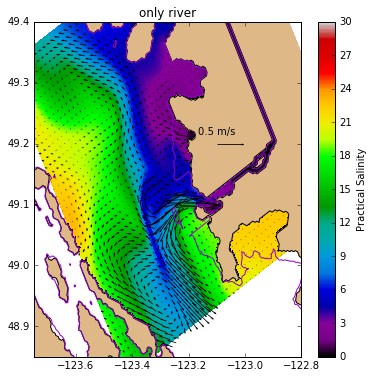

In [24]:
fig = plot_spatial_circulation(river_T,river_U,river_V,0,'only river')

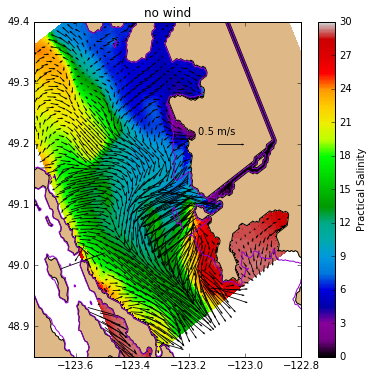

In [25]:
fig = plot_spatial_circulation(nowind_T,nowind_U,nowind_V,0,'no wind')

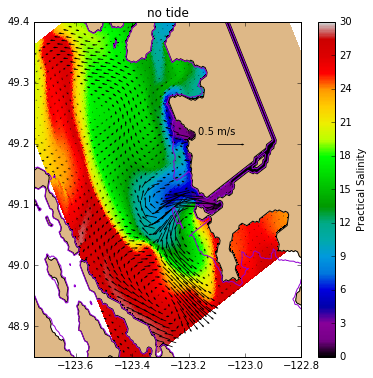

In [26]:
fig = plot_spatial_circulation(notide_T,notide_U,notide_V,0,'no tide')

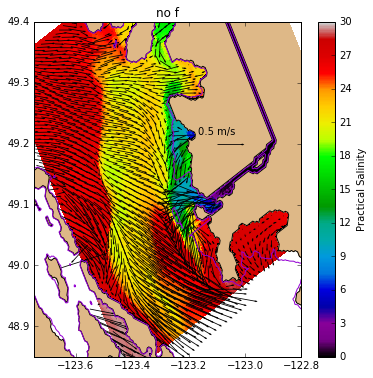

In [27]:
fig = plot_spatial_circulation(nof_T,nof_U,nof_V,0,'no f')

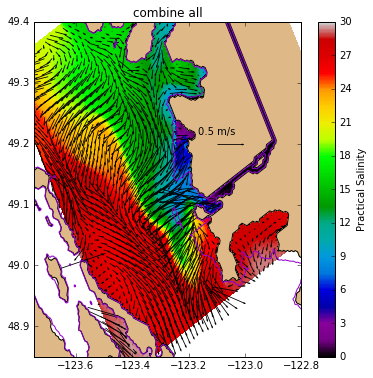

In [28]:
fig = plot_spatial_circulation(all_T,all_U,all_V,0,'combine all')